In [117]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statistics as stats

In [118]:
pd.options.display.max_columns = 50
data = pd.read_csv('/Users/kb/Ironhack/Labs/lab-imbalanced-data/customer_churn.csv')
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [119]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [120]:
data.columns=data.columns.str.lower()

In [121]:
data.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [122]:
data['totalcharges']=pd.to_numeric(data['totalcharges'], errors='coerce')

In [123]:
data.isna().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [124]:
stats.median(data['totalcharges'])

6296.75

In [125]:
data['totalcharges'] = data['totalcharges'].fillna(stats.median(data['totalcharges']))

In [126]:
data.isna().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

As you can see there is a huge imbalance in the representation of the two categories 

In [127]:
num = data.select_dtypes(np.number)
y = data['churn']
transformer = StandardScaler().fit(num)
scaled_x = transformer.transform(num)
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(scaled_x, y)
classification.score(scaled_x, y)

0.7907141842964646

With this imbalance, when we tried to fit the model (without any data cleaning) it still gave us an accuracy of nearly 80%

Note: Even if we just blindly say that each prediction is No, we would still get an accuracy of 

### Synthetic Minority Oversampling TEchnique (SMOTE)

In [128]:
num.head()

,seniorcitizen,tenure,monthlycharges,totalcharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [129]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
num = data.select_dtypes(np.number)
transformer = StandardScaler().fit_transform(num)

In [133]:
y = data['churn']
x_sm, y_sm = smote.fit_resample(transformer, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: churn, dtype: int64

In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=100)

In [135]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [136]:
classification.score(X_test, y_test)

0.7434782608695653

In [138]:
predictions = classification.predict(X_test)

[[772 280]
 [251 767]]


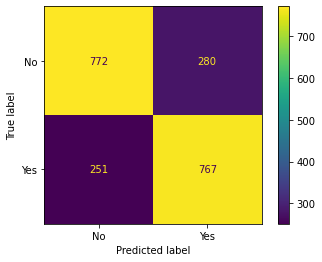

The Kappa of your model is: 0.49


In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

### UnderSampling using TomekLinks 

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [140]:
y.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [141]:
from imblearn.under_sampling import TomekLinks
y=data['churn']
num = data.select_dtypes(np.number)
transformer = StandardScaler().fit_transform(num)
tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_resample(transformer, y)
y_tl.value_counts()

No     4666
Yes    1869
Name: churn, dtype: int64

In [142]:
X_tl2, y_tl2 = tl.fit_resample(X_tl, y_tl)
y_tl2.value_counts()

No     4496
Yes    1869
Name: churn, dtype: int64

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tl2, y_tl2, test_size=0.2, random_state=100)

In [147]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [148]:
predictions = classification.predict(X_test)

[[805 100]
 [169 199]]


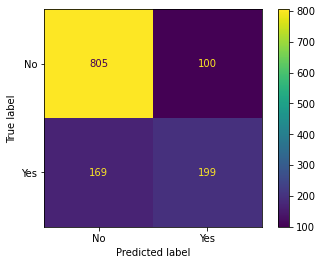

The Kappa of your model is: 0.46


In [149]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

In [61]:
# Similar way it works for multi label classification models 
# But it can be a little tricky 

In [56]:
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = churnData['Churn']

In [58]:
y[6000:7000] = 'Hello'
y.value_counts()

No       4445
Yes      1598
Hello    1000
Name: Churn, dtype: int64

In [59]:
tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X, y)
y_tl.value_counts()

No       3747
Yes      1598
Hello    1000
Name: Churn, dtype: int64

In [60]:
X_sm, y_sm = smote.fit_sample(X, y)
y_sm.value_counts()

Yes      4445
Hello    4445
No       4445
Name: Churn, dtype: int64

In [45]:
5174/(5174+1869)

0.7346301292063041

In [47]:
yes = data[data['churn']=='Yes']
no = data[data['churn']=='No']
data1=yes
data2=no.sample(data['churn'].value_counts()[1])

In [48]:
data1.shape

(1869, 21)

In [49]:
data2.shape

(1869, 21)

In [50]:
data_final=pd.concat([data1,data2], axis =0)

In [51]:
data_final.shape

(3738, 21)

In [55]:
yes = data[data['churn']=='Yes']
no = data[data['churn']=='No']

In [56]:
yesinc = yes.sample(5174, replace = True)

In [57]:
yesinc.shape

(5174, 21)

In [16]:
yesinc.drop_duplicates().shape

(1748, 21)

In [58]:
data_balanced=pd.concat([yesinc,no], axis =0)

In [60]:
data = pd.concat([yes,no], axis=0)
print(y.value_counts())
data.head()

No     5174
Yes    1869
Name: churn, dtype: int64


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
13,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes


In [62]:
#shuffling the data
data = data.sample(frac=1)
y.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [63]:
num = data.select_dtypes(np.number)
transformer = StandardScaler().fit(num)
scaled_x = transformer.transform(num)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(scaled_x, y)
classification.score(scaled_x, y)

0.7346301292063041

In [65]:
counts = y.value_counts()
yes = data[data['churn']=='Yes'].sample(counts[0], replace=True)
no = data[data['churn']=='No']
data = pd.concat([yes,no], axis=0)
data = data.sample(frac=1)
data['churn'].value_counts()

No     5174
Yes    5174
Name: churn, dtype: int64

In [66]:
counts = y.value_counts()
counts

No     5174
Yes    1869
Name: churn, dtype: int64

In [67]:
transformer = StandardScaler().fit(num)
transformed = transformer.transform(num)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(transformed, y)
classification.score(transformed, y)

0.7346301292063041

In [24]:
# pip install imblearn

In [70]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler()
transformer = StandardScaler().fit(num)
transformed = transformer.transform(transformed)
X_rus, y_rus = rus.fit_resample(transformed, y)

In [71]:
y.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [72]:
y_rus.value_counts()

Yes    1869
No     1869
Name: churn, dtype: int64

In [29]:
transformer = StandardScaler().fit(X_rus)
X = transformer.transform(X_rus)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X, y_rus)
classification.score(X, y_rus)

0.7316746923488496

In [30]:
ros = RandomOverSampler()
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = churnData['Churn']
X_ros, y_ros = ros.fit_resample(X, y)

In [31]:
y.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [32]:
y_ros.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [33]:
transformer = StandardScaler().fit(X_ros)
X = transformer.transform(X_ros)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X, y_ros)
classification.score(X, y_ros)

0.733475067645922